# Imports

In [89]:
import warnings
warnings.filterwarnings('ignore')
import collections
import csv
import datetime
import glob
import hashlib
import h5py
import itertools
import math
import operator
import os
import pickle
import random
import re
import string
import sys
import time
from tqdm import tqdm
import scipy as sp
import numpy as np
import pandas as pd
rseed = random.seed(42)
np.random.seed(rseed)
import theano as thno
import keras as krs
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import skimage.data
import skimage.transform
from sklearn import decomposition
from sklearn import feature_selection
from sklearn import grid_search
from sklearn import metrics
from sklearn import model_selection
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import utils
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib as mpl
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
mpl.rcParams['figure.figsize']=(12.0,4.0)
%matplotlib inline

# Load Data

Train data: http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip

Test data: http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip

Test labels: http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_GT.zip

In [90]:
# function to read train images
def load_train(rootpath):
    images = []
    labels = []
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/'
        gtFile = open(os.path.join(prefix, 'GT-'+ format(c, '05d') + '.csv'))
        gtReader = csv.reader(gtFile, delimiter=';')
        next(gtReader, None)
        for row in gtReader:
            images.append(skimage.data.imread(prefix + row[0]))
            labels.append(row[7])
        gtFile.close()
    return images, labels

In [91]:
# function to read test images
def load_test(datadir):
    images = []
    labels = []
    gtFile = open(os.path.join(datadir + '/', 'labels.csv'))
    gtReader = csv.reader(gtFile, delimiter=';')
    next(gtReader, None)
    for row in gtReader:
        images.append(skimage.data.imread(datadir + '/' + row[0]))
        labels.append(row[7])
    gtFile.close()
    return images, labels

In [92]:
# Load training and testing datasets.
datadir = "./gtsrb/"
train_datadir = os.path.join(datadir, "train")
test_datadir = os.path.join(datadir, "test")

In [93]:
# load train data
X_train_raw, y_train = load_train(train_datadir)
y_train = list(map(np.int, y_train))
assert(len(X_train_raw) == len(y_train))

# load test data
X_test_raw, y_test = load_test(test_datadir)
y_test = list(map(np.int, y_test))
assert(len(X_test_raw) == len(y_test))

# Data Summary & Exploration

In [94]:
# some info
n_train = len(X_train_raw)
n_test = len(X_test_raw)
n_classes = len(set(y_train))
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Number of classes = 43


In [95]:
# check image shape standardization
def check_img_shape(imgs):
    im_shapes = [x.shape for x in imgs]
    ims = set(im_shapes)
    if len(ims) > 1:
        print('Images not standardized! {} image shapes'.format(len(ims)))
        print('Example of largest image...')
        print()
        m = (0,0,0)
        for i in im_shapes:
            if i > m:
                m = i
        plt.imshow(imgs[im_shapes.index(m)])

Images not standardized! 2924 image shapes
Example of largest image...



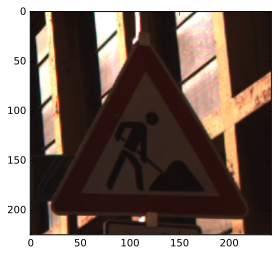

In [96]:
check_img_shape(X_train_raw)

Images not standardized! 1884 image shapes
Example of largest image...



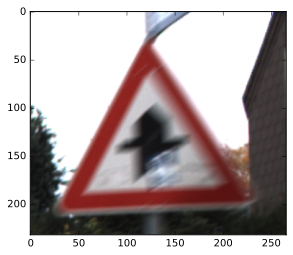

In [97]:
check_img_shape(X_test_raw)

In [98]:
# resize images to 32x32 for LeNet
def img_resize(imgs, dims=(32, 32, 3)):
    reimgs = []
    for i, img in enumerate(imgs):
        if img.shape != dims:
            img = cv2.resize(img, (dims[0], dims[1]), interpolation=cv2.INTER_AREA)
            reimgs.append(img)
        else:
            reimgs.append(img)
    return reimgs

In [99]:
# resize train images
X_train_resize = img_resize(X_train_raw)
assert(len(X_train_resize) == len(X_train_raw))

# resize test images
X_test_resize = img_resize(X_test_raw)
assert(len(X_test_resize) == len(X_test_raw))
X_test = X_test_resize

In [100]:
# check train
check_img_shape(X_train_resize)

In [101]:
# check test
check_img_shape(X_test_resize)

In [102]:
# shuffle data to get rid of sequential images, etc.
X_train, y_train = utils.shuffle(X_train_resize, y_train)
X_test, y_test = utils.shuffle(X_test_resize, y_test)
X_test = np.array(X_test)

# add validation set
X_train, X_cv, y_train, y_cv = model_selection.train_test_split(X_train,
                                                                y_train,
                                                                test_size=0.2,
                                                                random_state=rseed)
assert(len(X_train) == len(y_train))
assert(len(X_cv) == len(y_cv))

In [103]:
# some info
n_train = len(X_train)
n_test = len(X_test)
n_cv = len(X_cv)
n_classes = len(set(y_train))
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of cv examples =", n_cv)
print("Number of classes =", n_classes)

Number of training examples = 31367
Number of testing examples = 12630
Number of cv examples = 7842
Number of classes = 43


In [104]:
def class_group(_y):
    index = {}
    labels = set(_y)
    for i, y in enumerate(_y):
        if y not in index.keys() :
            index[y] = [i]
        else :
            index[y].append(i)
    return index

In [105]:
def display_images(_x, _y, i_start='random') :
    img_index = class_group(_y)
    labels = list(set(_y))[::-1]
    fig, axes = plt.subplots(4, 8, figsize=(12, 4))
    for ax in axes.flatten() :
        if labels : 
            i_img=0
            if i_start == 'random':
                i_img = random.choice(img_index[labels.pop()])  
            else : 
                i_img = img_index[labels.pop()][i_start]
            ax.imshow(_x[i_img])
        ax.axis('off')

In [106]:
def plot_dist(_y, title=None, ax=None, **kwargs) :
    if not ax :
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(_y, np.arange(-0.5, n_classes+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5,n_classes-0.5)
    if 'label' in kwargs : ax.legend()
    if title : ax.set_title(title)

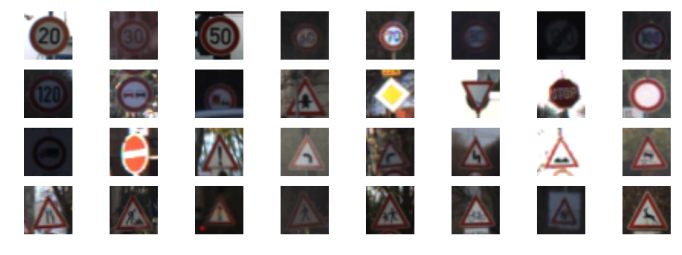

In [107]:
display_images(X_train, y_train)

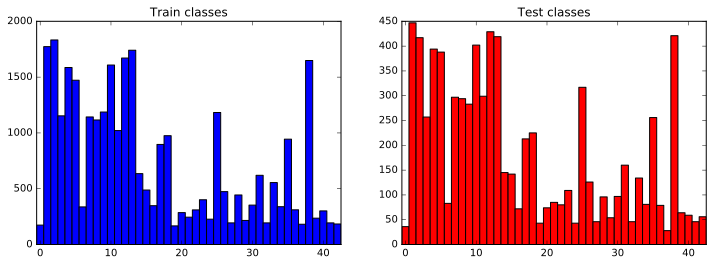

In [108]:
fig,ax = plt.subplots(1,2, figsize=(12,4))
plot_dist(y_train, title='Train classes', ax=ax[0], color='b')
plot_dist(y_cv, title='Test classes', ax=ax[1], color='r')

# Preprocessing

## 1. Describe how, and identify where in your code, you preprocessed the image data. What tecniques were chosen and why did you choose these techniques?

I attempted normalizing images in greyscale space to remove variations due to lighting and image quality. This provided significant improvement in the model accuracy, hence it is reused in the analysis pipeline. However using prebuilt lines and edges (Canny+Hough) did not improve accuracy. Likely due to the CNN finding these features on its own. After submission, I included the image augmentation found [here](https://medium.com/@vivek.yadav/improved-performance-of-deep-learning-neural-network-models-on-traffic-sign-classification-using-6355346da2dc#.c165ks3ja) to improve accruacy further.

In [109]:
# grey scale normalize
def grey_norm(image):
    gs = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l = gs[:,:,0]
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(4,4))
    cl = clahe.apply(l)
    gs[:,:,0] = cl
    img =  cv2.cvtColor(gs, cv2.COLOR_LAB2BGR)
    new_img = np.zeros(image.shape)
    for i in range(3) :
        new_img[:,:,i] = img[:,:,i]/255
    return new_img

In [110]:
# find edges via Canny algo
#def edges(image, sigma=0.33):
#    v = np.median(image)
#    lower = int(max(0, (1.0 - sigma) * v))
#    upper = int(min(255, (1.0 + sigma) * v))
#    edged = cv2.Canny(image, lower, upper)
#    return edged
#
# hough transform on edges
#def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
#    lines = cv2.HoughLinesP(img, rho, theta, threshold,
#                            minLineLength=min_line_len,
#                            maxLineGap=max_line_gap)
#    return lines
#
# combine greyscale, norm, edges
# ***UNUSED***
#rand = np.random.randint(0,len(X_train),1)[0]
#img = X_train[rand]
#s_img = (img * 255).round().astype(np.uint8)
#g_img = grey_norm(s_img)
#c_img = edges(g_img)
#h_img = hough_lines(c_img, 1, np.pi/180, 1, 1, 3)
#for line in h_img:
#    line = line[0]
#    cv2.line(img, (line[0], line[1]), (line[2], line[3]), (255,0,0), 1)
#plt.imshow(g_img, cmap='gray')

In [111]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = 0.25 + np.random.uniform()
    image1[:,:,2] = image1[:,:,2] * random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

In [112]:
def transform_image(img, ang_range, shear_range, trans_range, brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.
    A Random uniform distribution is used to generate different parameters for transformation
    '''

    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
        img = augment_brightness_camera_images(img)

    return img

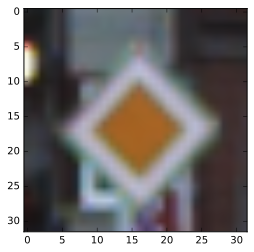

In [113]:
rand = np.random.randint(0,len(X_train),1)[0]
img = X_train[rand]
plt.imshow(img)

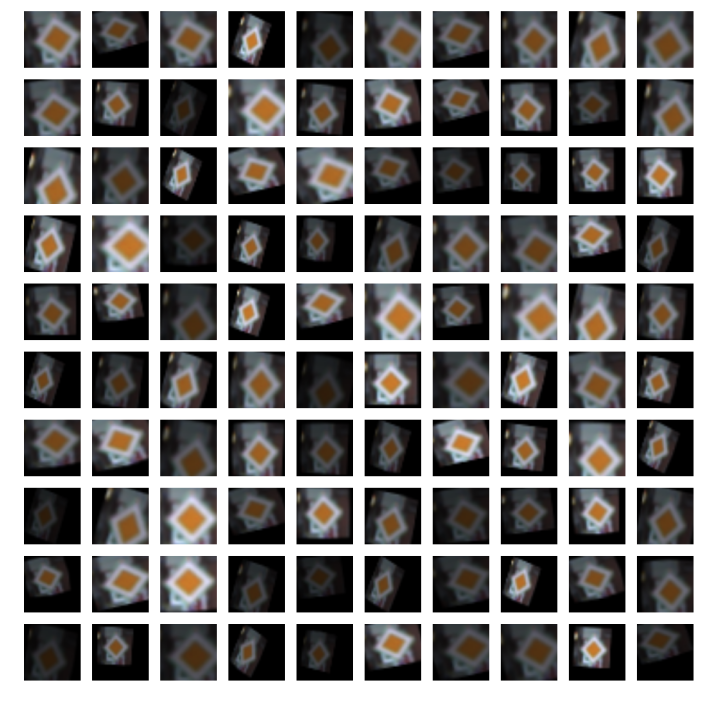

In [114]:
gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02)
plt.figure(figsize=(12,12))
for i in range(100):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = transform_image(X_train[rand], 20, 10, 5, brightness=1)
    plt.subplot(10,10,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## 2. Describe how, and identify where in your code, you set up training, validation and testing data. How much data was in each set? Explain what techniques were used to split the data into these sets.

* Data comes in train/test samples in original download. I used scikit-learn train test split module to split the training data into 80/20 sample for training and cross-validation.
* All data is shuffled multiple times and during batch training.
* I used the data augmentation and perturb routines from the linked Medium article to create 5000 examples per class.

In [115]:
def perturb_data(X_data, y_data):
    X_old, y_old = [], []
    X_new, y_new = [], []
    images_pbar = tqdm(X_data, unit='images', desc='Original data perturbation')
    for i,img in enumerate(images_pbar) :
        if i%2 == 0 : 
            X_old.append(img) 
            y_old.append(y_data[i])
        else :
            X_new.append(transform_image(img, 20, 10, 5, brightness=1))
            y_new.append(y_data[i])
    return (np.array(X_old), np.array(y_old), 
            np.array(X_new), np.array(y_new))

In [116]:
def augment_data(X_data, y_data, n=300):
    X_data_fake, y_data_fake = [],[]
    img_index = class_group(y_data)
    labels_pbar = tqdm(range(n_classes), unit='class', desc='Data augmentation')
    for label in labels_pbar:
        n_fake = n-len(img_index[label])
        if n_fake <= 0 : continue
        for i in range(n_fake):
            i_img = random.choice(img_index[label])
            img = X_data[i_img]
            X_data_fake.append(transform_image(img, 20, 10, 5, brightness=1))
            y_data_fake.append(label)
    return np.array(X_data_fake), np.array(y_data_fake)

In [117]:
# generate training data with 5000 images per class
print('Training dataset augmentation')
X_train_actual, y_train_actual, X_train_pert, y_train_pert = perturb_data(X_train, y_train)
X_train_aug, y_train_aug = augment_data(X_train, y_train, n=5000)


Original data perturbation:   5%|▌         | 1724/31367 [00:00<00:01, 17229.79images/s]

Training dataset augmentation



Data augmentation: 100%|██████████| 43/43 [00:19<00:00,  2.01class/s]


In [118]:
# generate cv data with 2500 images per class
print('CV dataset augmentation')
X_cv_actual, y_cv_actual, X_cv_pert, y_cv_pert = perturb_data(X_cv, y_cv)
X_cv_aug, y_cv_aug = augment_data(X_cv, y_cv, n=2500)

Original data perturbation:  23%|██▎       | 1806/7842 [00:00<00:00, 18045.05images/s]

CV dataset augmentation


Data augmentation: 100%|██████████| 43/43 [00:10<00:00,  3.94class/s]


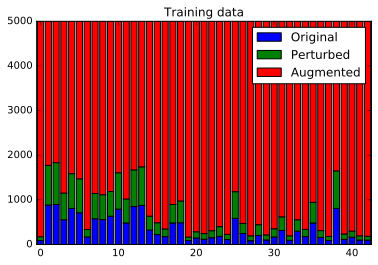

In [119]:
# check if distributions are as expected
plot_dist([y_train_actual, y_train_pert, y_train_aug],
          title='Training data',
          label=['Original','Perturbed','Augmented'])

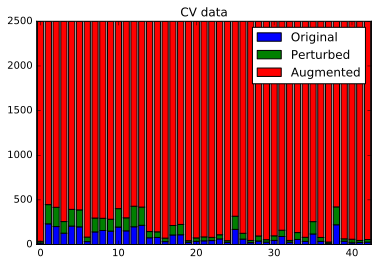

In [120]:
# check if distributions are as expected
plot_dist([y_cv_actual, y_cv_pert, y_cv_aug],
          title='CV data',
          label=['Original','Perturbed','Augmented'])

In [121]:
# combine training data, shuffle and apply pre-processing 
print('Preparing training data...')
X_train = np.concatenate((X_train_actual, X_train_pert, X_train_aug))
y_train = np.concatenate((y_train_actual, y_train_pert, y_train_aug))
X_train, y_train = utils.shuffle(X_train, y_train)
images_pbar = tqdm(X_train, unit='images')
X_train = np.zeros(X_train.shape)
for i, img in enumerate(images_pbar) : 
    X_train[i] = grey_norm(img) 
print('Done')

Preparing training data...


100%|██████████| 215000/215000 [00:29<00:00, 7272.15images/s]

Done


In [122]:
# combine validation data, shuffle and apply pre-processing 
print('Preparing validation data...')
X_cv = np.concatenate((X_cv_actual, X_cv_pert, X_cv_aug))
y_cv = np.concatenate((y_cv_actual, y_cv_pert, y_cv_aug))
X_cv, y_cv = utils.shuffle(X_cv, y_cv)
images_pbar = tqdm(X_cv, unit='images')
X_cv = np.zeros(X_cv.shape)
for i,img in enumerate(images_pbar) : 
    X_cv[i] = grey_norm(img) 
print('Done')

Preparing validation data...


100%|██████████| 107500/107500 [00:14<00:00, 7300.41images/s]

Done


In [123]:
# pre-process test set images
print('Preparing test data...')
X_test, y_test = utils.shuffle(X_test, y_test)
images_pbar = tqdm(X_test, unit='images')
X_test_norm = np.zeros(X_test.shape)
for i, img in enumerate(images_pbar) : 
    X_test_norm[i] = grey_norm(img) 

  6%|▌         | 710/12630 [00:00<00:01, 7099.84images/s]

Preparing test data...


100%|██████████| 12630/12630 [00:01<00:00, 7175.24images/s]


# Model Architecture

## 3. Describe, and identify where in your code, what your final model architecture looks like including model type, layers, layer sizes, connectivity, etc.)

I used the well-known VGG network topology for my final model:
http://www.robots.ox.ac.uk/~vgg/practicals/cnn/

This has 6 convolutional layers (all ReLu activations), 3 pooling layers, and 3 fully connected layers.

In [124]:
def convnet(x, mu, sigma):

    # Layer 1: Convolutional. Input = 32x32x3. Output = 32x32x32.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 32), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b

    # ReLu Activation.
    conv1 = tf.nn.relu(conv1)

    # Layer 2: Convolutional. Input = 32x32x32. Output = 32x32x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    
    # ReLu Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 32x32x32. Output = 16x16x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2 = tf.nn.dropout(conv2, keep_prob_conv) # dropout

    # Layer 3: Convolutional. Input = 16x16x32. Output = 16x16x64.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(64))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='SAME') + conv3_b

    # ReLu Activation.
    conv3 = tf.nn.relu(conv3)

    # Layer 4: Convolutional. Input = 16x16x32. Output = 16x16x64.
    conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros(64))
    conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='SAME') + conv4_b
    
    # ReLu Activation.
    conv4 = tf.nn.relu(conv4)

    # Pooling. Input = 16x16x64. Output = 8x8x64.
    conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv4 = tf.nn.dropout(conv4, keep_prob_conv) # dropout

    # Layer 5: Convolutional. Input = 8x8x64. Output = 8x8x128.
    conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = mu, stddev = sigma))
    conv5_b = tf.Variable(tf.zeros(128))
    conv5   = tf.nn.conv2d(conv4, conv5_W, strides=[1, 1, 1, 1], padding='SAME') + conv5_b

    # ReLu Activation.
    conv5 = tf.nn.relu(conv5)

    # Layer 6: Convolutional. Input = 8x8x128. Output = 8x8x128.
    conv6_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 128), mean = mu, stddev = sigma))
    conv6_b = tf.Variable(tf.zeros(128))
    conv6   = tf.nn.conv2d(conv5, conv6_W, strides=[1, 1, 1, 1], padding='SAME') + conv6_b

    # ReLu Activation.
    conv6 = tf.nn.relu(conv6)
    
    # Pooling. Input = 8x8x128. Output = 4x4x128.
    conv6 = tf.nn.max_pool(conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv6 = tf.nn.dropout(conv6, keep_prob_conv) # dropout

    # Flatten. Input = 4x4x128. Output = 2048.
    fc0   = flatten(conv6)
    
    # Layer 7: Fully Connected. Input = 2048. Output = 128.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(2048, 128), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(128))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # ReLu Activation.
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob) # dropout

    # Layer 8: Fully Connected. Input = 128. Output = 128.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(128, 128), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(128))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # ReLu Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob) # dropout

    # Layer 9: Fully Connected. Input = 128. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    return logits

# Train, Validate and Test

## 4. Describe how, and identify where in your code, you trained your model. The discussion can include the type of optimizer, the batch size, number of epochs and any hyperparameters such as learning rate.

In general, learning rates of 0.001 to 0.003 perform well, and 30 epochs was sufficent in trial to achieve good accuracy without the danger of overfitting. ADAM optimizer was selected because of its momentum feature versus traditional SGD.

In [125]:
# hyperparameters
learning_rate = 0.001
epochs = 30
batch_size = 128
mu = 0
sigma = 0.1

# graph
x = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int32, [None])
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)
keep_prob_conv = tf.placeholder(tf.float32)

# ops
logits = convnet(x, mu, sigma)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [126]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset + batch_size], y_data[offset:offset + batch_size]
        accuracy = sess.run(accuracy_operation,
                            feed_dict={x: batch_x,
                                       y: batch_y,
                                       keep_prob: 1.0,
                                       keep_prob_conv: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [127]:
def y_predict(X_data):
    num_examples = len(X_data)
    y_pred = np.zeros(num_examples, dtype=np.int32)
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x = X_data[offset:offset + batch_size]
        y_pred[offset:offset + batch_size] = sess.run(tf.argmax(logits, 1), 
                                                      feed_dict={x:batch_x,
                                                                 keep_prob:1.0,
                                                                 keep_prob_conv:1.0})
    return y_pred

In [128]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training...")
    print()
    for i in range(epochs):
        X_train, y_train = utils.shuffle(X_train, y_train)
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x,
                                                    y: batch_y,
                                                    keep_prob: 1.0,
                                                    keep_prob_conv: 1.0})
        validation_accuracy = evaluate(X_cv, y_cv)
        print("Epoch {}: Validation Accuracy = {:.3f}".format(i+1, validation_accuracy))
    saver.save(sess, './vgg')
    print("Model saved")

Training...

Epoch 1: Validation Accuracy = 0.930
Epoch 2: Validation Accuracy = 0.961
Epoch 3: Validation Accuracy = 0.972
Epoch 4: Validation Accuracy = 0.971
Epoch 5: Validation Accuracy = 0.973
Epoch 6: Validation Accuracy = 0.980
Epoch 7: Validation Accuracy = 0.976
Epoch 8: Validation Accuracy = 0.984
Epoch 9: Validation Accuracy = 0.986
Epoch 10: Validation Accuracy = 0.982
Epoch 11: Validation Accuracy = 0.985
Epoch 12: Validation Accuracy = 0.983
Epoch 13: Validation Accuracy = 0.982
Epoch 14: Validation Accuracy = 0.985
Epoch 15: Validation Accuracy = 0.984
Epoch 16: Validation Accuracy = 0.985
Epoch 17: Validation Accuracy = 0.987
Epoch 18: Validation Accuracy = 0.983
Epoch 19: Validation Accuracy = 0.983
Epoch 20: Validation Accuracy = 0.987
Epoch 21: Validation Accuracy = 0.986
Epoch 22: Validation Accuracy = 0.988
Epoch 23: Validation Accuracy = 0.983
Epoch 24: Validation Accuracy = 0.988
Epoch 25: Validation Accuracy = 0.987
Epoch 26: Validation Accuracy = 0.985
Epoch 27

In [129]:
# initial model
with tf.Session() as sess:
    saver.restore(sess, "./vgg")
    y_pred = evaluate(X_test, y_test)
    y_pred = y_predict(X_test)
    test_accuracy = sum(y_test == y_pred)/len(y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.947


## 5. Describe the approach taken for finding a solution. Include in the discussion the results on the training, validation and test sets and where in the code these were calculated.

The approach is a rote one: train, cross-validate, test on unseen data. The classes are not osentisbly skewed so accuracy is my metric rather than recall or precision. The training data is augmented as described in preprocessing. Training achieves an accuracy of ~98% and is insensitive to more epochs and the optimizer, the latter two simply make the model converge more slowly. This indicates to me that the accuracy is a function of preprocessing and topology moreso than training method or tuning. The test set returned an accuracy of ~95%, not ideal, but a good start on a relatively untuned model.

# Test on New Images

## 1. Choose five German traffic signs found on the web and provide them in the report. For each image, discuss what quality or qualities might be difficult to classify.

Difficult? The model hasn't seen any images like these. They are also taken from Google image search, so they have watermarks and are likely *too* detailed due to resolution, clarity, and coloring.

In [135]:
sign_names = pd.read_csv('signnames.csv')

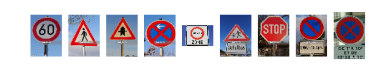

In [147]:
import glob
img_files = glob.glob('new_signs/*.jpg')
n_new = len(img_files)
new_data = np.zeros((n_new, 32,32,3), dtype=np.uint8)
fig, ax = plt.subplots(1,n_new)
for i in range(n_new) :
    img = plt.imread(img_files[i])
    ax[i].imshow(img)
    ax[i].axis('off')
    img = cv2.resize(img, (32,32), interpolation=cv2.INTER_AREA)
    img = augment_brightness_camera_images(img)
    new_data[i] = img

In [148]:
def y_predict_model(X_data, top_k=1):
    num_examples = len(X_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
    with tf.Session() as sess:
        saver.restore(sess, "./vgg")
        y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=top_k), 
                                  feed_dict={x: X_data,
                                             keep_prob: 1.0,
                                             keep_prob_conv: 1.0})
    return y_prob, y_pred

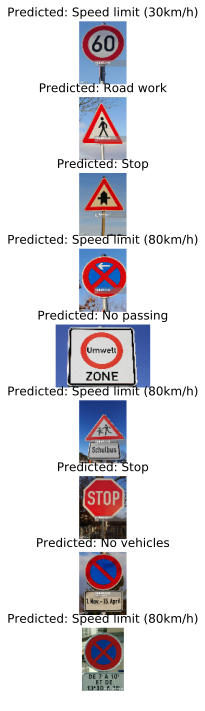

In [149]:
# predict
y_prob, y_pred = y_predict_model(new_data)

# show the prediction results
fig, ax = plt.subplots(n_new, 1, figsize=(12,12))
for i in range(n_new) :
    img = plt.imread(img_files[i])
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title('Predicted: ' + sign_names.iloc[y_pred[i][0]]['SignName'])

Accuracy is 11%.

## 2. Discuss the model's predictions on these new traffic signs and compare the results to predicting on the test set. Identify where in your code predictions were made. At a minimum, discuss what the predictions were, the accuracy on these new predictions, and compare the accuracy to the accuracy on the test set.

11% new, unseen versus 95% in test. Predictions are provided above.

In [150]:
def top_predictions(X_data) :
    n_examples = len(X_data)
    fig, ax = plt.subplots(n_examples, 2,figsize=(10,8))
    prob, pred = y_predict_model(X_data, top_k=3)
    for i in range(n_examples) :
        labels = pred[i]
        names = [sign_names.iloc[l]['SignName'] for l in labels]
        bar_locations = np.arange(3)[::-1]
        ax[i,0].imshow(X_data[i])
        ax[i,0].axis('off')
        ax[i,1].barh(bar_locations, prob[i])
        ax[i,1].set_yticks(0.5+bar_locations)
        ax[i,1].set_yticklabels(names)
        ax[i,1].yaxis.tick_right()
        ax[i,1].set_xlim([0,1])
    ax[0,1].set_title('Model Prediction')
    fig.tight_layout()    

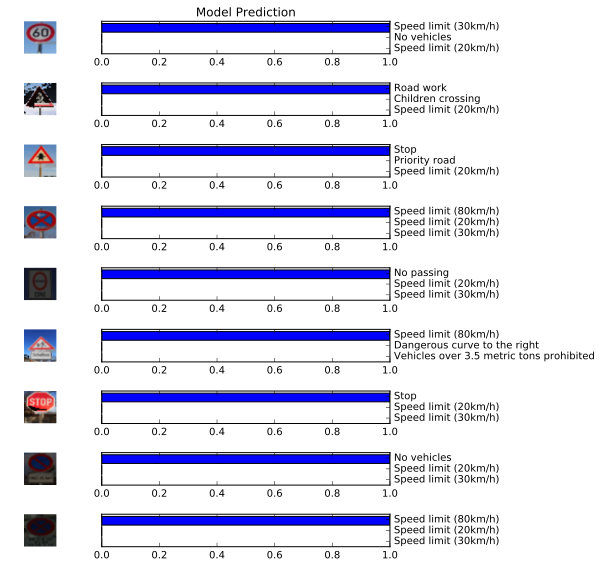

In [151]:
top_predictions(new_data)

## 3. Describe how certain the model is when predicting on each of the five new images by looking at the softmax probabilities for each prediction and identify where in your code softmax probabilities were outputted.

The model strangely has no uncertainty in selecting the class for each image. The images are too high quality and require more preprocessing to be similar to the images the model trained on.